# Exploratory Data Analysis: 2023/24 Premier League Season

This notebook analyzes match-level data from the 2023/2024 Premier League season. The goal is to identify patterns in team performance, goal scoring, home/away advantage, and matchday dynamics. This supports recruitment, performance evaluation, and tactical insights.


In [117]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
matches_df = pd.read_csv('../data/matches_clean_20250720_223207.csv')

In [119]:
matches_df.head()

,match_id,date,match_status,matchday,stage,home_team,away_team,home_goals,away_goals,result
0,435943,2023-08-11 19:00:00+00:00,FINISHED,1,REGULAR_SEASON,Burnley FC,Manchester City FC,0,3,A
1,435944,2023-08-12 12:00:00+00:00,FINISHED,1,REGULAR_SEASON,Arsenal FC,Nottingham Forest FC,2,1,H
2,435945,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,AFC Bournemouth,West Ham United FC,1,1,D
3,435946,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Brighton & Hove Albion FC,Luton Town FC,4,1,H
4,435947,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Everton FC,Fulham FC,0,1,A


In [120]:
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   match_id      380 non-null    int64 
 1   date          380 non-null    object
 2   match_status  380 non-null    object
 3   matchday      380 non-null    int64 
 4   stage         380 non-null    object
 5   home_team     380 non-null    object
 6   away_team     380 non-null    object
 7   home_goals    380 non-null    int64 
 8   away_goals    380 non-null    int64 
 9   result        380 non-null    object
dtypes: int64(4), object(6)
memory usage: 29.8+ KB


In [121]:
matches_df['goal_difference'] = matches_df['home_goals'] - matches_df['away_goals']
matches_df['total_goals'] = matches_df['home_goals'] + matches_df['away_goals']
matches_df['is_draw'] = matches_df['result'] == 'D'
matches_df['home_win'] = matches_df['result'] == 'H'
matches_df['away_win'] = matches_df['result'] == 'A'

In [122]:
matches_df.head()

,match_id,date,match_status,matchday,stage,home_team,away_team,home_goals,away_goals,result,goal_difference,total_goals,is_draw,home_win,away_win
0,435943,2023-08-11 19:00:00+00:00,FINISHED,1,REGULAR_SEASON,Burnley FC,Manchester City FC,0,3,A,-3,3,False,False,True
1,435944,2023-08-12 12:00:00+00:00,FINISHED,1,REGULAR_SEASON,Arsenal FC,Nottingham Forest FC,2,1,H,1,3,False,True,False
2,435945,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,AFC Bournemouth,West Ham United FC,1,1,D,0,2,True,False,False
3,435946,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Brighton & Hove Albion FC,Luton Town FC,4,1,H,3,5,False,True,False
4,435947,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Everton FC,Fulham FC,0,1,A,-1,1,False,False,True


# Exploratory Data Analysis (EDA)

- Which team had the most home wins?

In [123]:
home_wins = matches_df[matches_df['result'] == 'H']
home_win_counts = home_wins['home_team'].value_counts()
top_home_team = home_win_counts.idxmax()
top_home_wins = home_win_counts.max()
print(f'Team with the most home wins : {top_home_team} ({top_home_wins})')

Team with the most home wins : Arsenal FC (15)


- Which team scored the most goals overall?

In [124]:
home_goals_df = matches_df.groupby('home_team')['home_goals'].sum()
away_goals_df = matches_df.groupby('away_team')['away_goals'].sum()
total_goals = home_goals_df.add(away_goals_df, fill_value=0)
top_scorer_team = total_goals.idxmax()
top_scorer_goals = total_goals.max()
print(f" Team with most total goals: {top_scorer_team} ({int(top_scorer_goals)} goals)")

 Team with most total goals: Manchester City FC (96 goals)


- What was the average number of goals per match?

In [125]:
average_goals_per_match = (matches_df['total_goals'].sum() / 380).round(2)
print(f'Average goals scored per match : {average_goals_per_match}')

Average goals scored per match : 3.28


- Was there a home team advantage?

In [126]:
home_wins = matches_df[matches_df['result'] == 'H']
home_win_count = home_wins['home_win'].count()
away_wins =  matches_df[matches_df['result'] == 'A']
away_win_count = away_wins['away_win'].count()
print(f'Home wins: {home_win_count}')
print(f'Away wins: {away_win_count}')
print(f'Home teams win {home_win_count - away_win_count} more matches than away teams throughout the season')
print('There is an home advantage')

Home wins: 175
Away wins: 123
Home teams win 52 more matches than away teams throughout the season
There is an home advantage


- How often did matches end in a draw?

In [127]:
drawn_match = matches_df[matches_df['is_draw'] == True]
drawn_match_count = drawn_match['is_draw'].count()
drawn_match_count
print(f'There are {drawn_match_count} drawn matches')

There are 82 drawn matches


- What’s the most common scoreline?

In [128]:
# Create a scoreline column
matches_df['scoreline'] = matches_df['home_goals'].astype(str) + " - " + matches_df['away_goals'].astype(str)

#  Count each scoreline
scoreline_counts = matches_df['scoreline'].value_counts()

# Step 3: Get the most common
most_common_scoreline = scoreline_counts.idxmax()
most_common_count = scoreline_counts.max()

print(f" Most common scoreline: {most_common_scoreline} ({most_common_count} times)")

 Most common scoreline: 1 - 1 (38 times)


- Is there a pattern in total goals across matchdays?

In [129]:
goals_by_matchday = matches_df.groupby('matchday')['total_goals'].sum().sort_index()

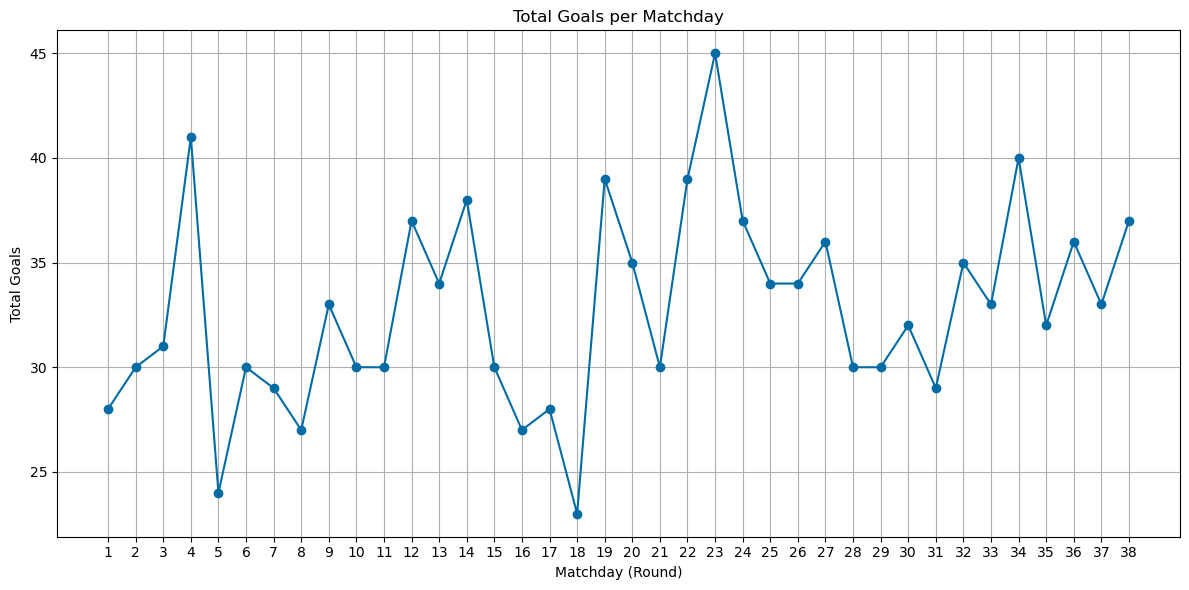

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(goals_by_matchday.index, goals_by_matchday.values, marker='o', linestyle='-')
plt.title("Total Goals per Matchday")
plt.xlabel("Matchday (Round)")
plt.ylabel("Total Goals")
plt.grid(True)
plt.xticks(range(1, 39))  # Matchdays 1 to 38
plt.tight_layout()
plt.show()

In [139]:
matchday_23 = matches_df[matches_df['matchday'] == 23]
matchday_23 = matchday_23[['home_team','away_team', 'total_goals','scoreline']]
matchday_23


,home_team,away_team,total_goals,scoreline
220,Everton FC,Tottenham Hotspur FC,4,2 - 2
221,Brighton & Hove Albion FC,Crystal Palace FC,5,4 - 1
222,Burnley FC,Fulham FC,4,2 - 2
223,Newcastle United FC,Luton Town FC,8,4 - 4
224,Sheffield United FC,Aston Villa FC,5,0 - 5
225,AFC Bournemouth,Nottingham Forest FC,2,1 - 1
226,Chelsea FC,Wolverhampton Wanderers FC,6,2 - 4
227,Manchester United FC,West Ham United FC,3,3 - 0
228,Arsenal FC,Liverpool FC,4,3 - 1
229,Brentford FC,Manchester City FC,4,1 - 3


In [140]:
print(f'The matchday with the most goals: Matchday 23 ({matchday_23['total_goals'].sum()})')

The matchday with the most goals: Matchday 23 (45)


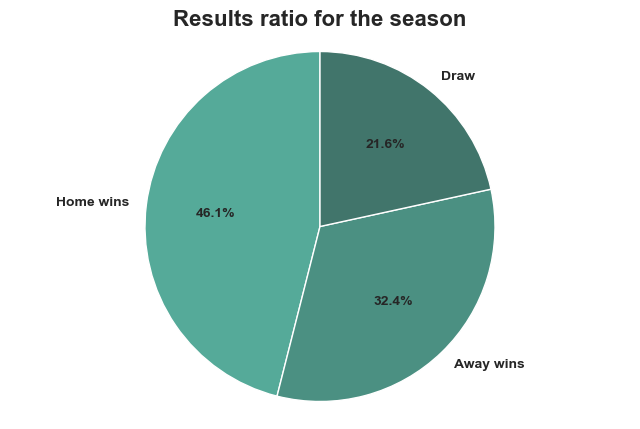

In [90]:
result = matches_df['result'].value_counts()

sns.set_style("whitegrid")
sns.set_palette('dark:#5A9_r')


plt.figure(figsize=(8, 5))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

wedges, texts, autotexts = plt.pie(
    result,
    labels=['Home wins', 'Away wins','Draw'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
plt.title('Results ratio for the season', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

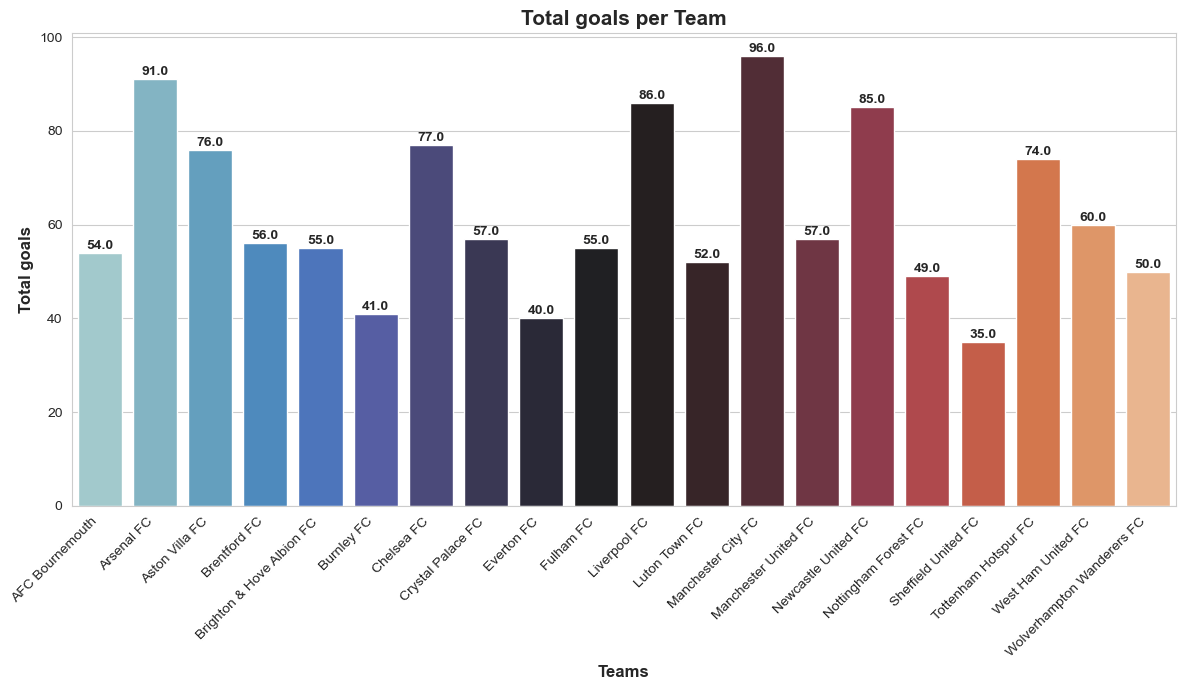

In [102]:
sns.set_style("whitegrid")

# Create the barplot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    x= total_goals.index,
    y= total_goals.values,
    hue= total_goals.index,
    palette="icefire",
    legend=False    
)

# Add value labels on top of each bar
for i, v in enumerate(total_goals.values):
    barplot.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Teams', fontsize=12, fontweight='bold')
plt.ylabel('Total goals', fontsize=12, fontweight='bold')
plt.title('Total goals per Team', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Top 10 Scorelines'}, xlabel='scoreline'>

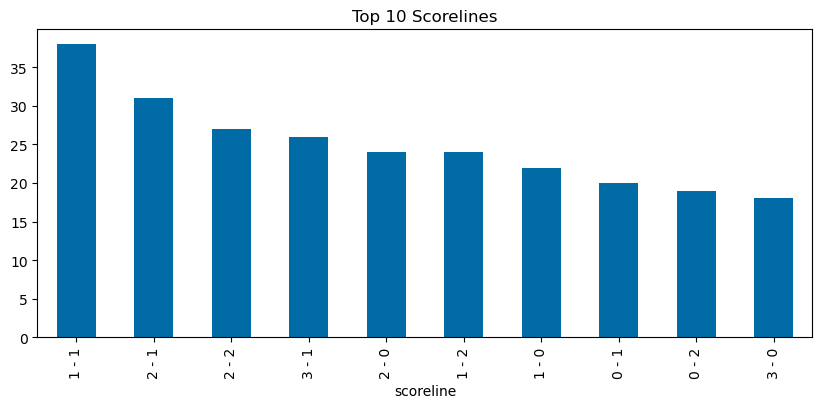

In [107]:
plt.style.use('tableau-colorblind10')
matches_df['scoreline'].value_counts().head(10).plot(kind='bar', figsize=(10, 4), title='Top 10 Scorelines')

Text(0.5, 1.0, 'Distribution of Total Goals per Match')

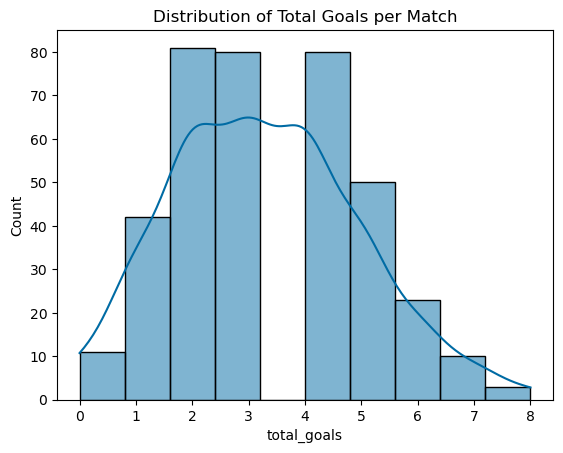

In [111]:
sns.histplot(matches_df['total_goals'],bins=10 , kde=True)
plt.title('Distribution of Total Goals per Match')

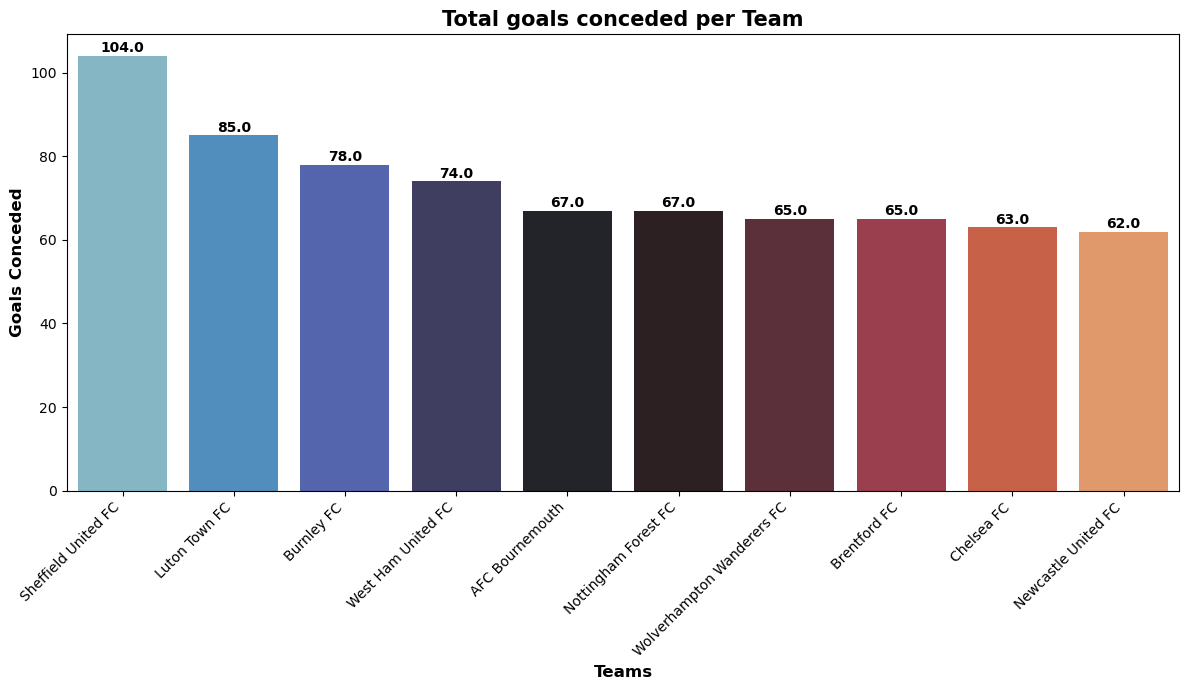

In [113]:
goals_conceded = matches_df.groupby('home_team')['away_goals'].sum() + matches_df.groupby('away_team')['home_goals'].sum()
most_gc = goals_conceded.sort_values(ascending=False).head(10)


# Create the barplot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    x= most_gc.index,
    y= most_gc.values,
    hue= most_gc.index,
    palette="icefire",
    legend=False    
)

# Add value labels on top of each bar
for i, v in enumerate(most_gc.values):
    barplot.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Teams', fontsize=12, fontweight='bold')
plt.ylabel('Goals Conceded', fontsize=12, fontweight='bold')
plt.title('Total goals conceded per Team', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 📈 Summary of Insights

- Most matches ended in a 1 - 1 scoreline.
- Manchester City had the highest total goals, while Sheffield United FC conceded the most.
- Home teams won approximately 46% of matches, showing a clear home-field advantage.
- Matchday 22 had a spike in goals, possibly due to derby or holiday fixtures.
